# Experiment Two

The first study, called `experiment-two`, looked at the effect of social influence on curiousity, using upvotes as proxy for social interest. Below we analyze the responses to test the hypothesis that the same questions, when given higher upvotes, receive higher scores from participants with regards to curiousity. And, further, whether this translates into participants being more likely to choose to view the answers to the questions with higher upvotes.

## Analysis

In [2]:
%load_ext pycodestyle_magic

In [3]:
# Analytical Tools
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# General Utilities
import math
import json
import pprint
import itertools
import importlib

# Custom Utilities
import utilities.processing_two as processing
import utilities.plotting as plotting
import utilities.describe as describe

# Some settings
from IPython.display import Markdown, display
log = pprint.pprint
space = lambda: print()
printmd = lambda text: display(Markdown(text))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/hermish/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Reading Data and Defining Constants

In [4]:
FILE_NAMES = [
    'raw-data/questions-and-answers-clean.json',
    'raw-data/judgments.json',
    'raw-data/responses-two.json'
]

NUM_QUESTIONS, NUM_JUDGEMENTS = 10, 7
GROUP_SIZE = NUM_QUESTIONS // 2

ALL_LABELS = processing.get_all_labels(NUM_QUESTIONS)
LOW_LABELS, HIGH_LABELS = ALL_LABELS[:GROUP_SIZE], ALL_LABELS[GROUP_SIZE:]
JUDGMENT_LABELS = processing.get_judgment_labels(NUM_JUDGEMENTS)

LITERALS = []
for name in FILE_NAMES[:2]:
    with open(name) as file:
         LITERALS.append(json.load(file))
with open(FILE_NAMES[2]) as file:
    master_responses = [json.loads(line) for line in file if line]

### Reading Responses into Data
Creates a `DataFrame` based on the survey data.

In [5]:
col_labels = processing.get_col_labels(NUM_QUESTIONS,
                                       NUM_JUDGEMENTS)
data = {label: [] for label in col_labels}

In [6]:
processing.fill_experiment_three_data(data, master_responses)

In [7]:
data = pd.DataFrame(data)
data = data[data.consent == 1]
print(data.size, len(data))
data.head()

30401 301


,consent,high_q0_choice,high_q0_index,high_q0_j0,high_q0_j1,high_q0_j2,high_q0_j3,high_q0_j4,high_q0_j5,high_q0_j6,...,low_q4_choice,low_q4_index,low_q4_j0,low_q4_j1,low_q4_j2,low_q4_j3,low_q4_j4,low_q4_j5,low_q4_j6,low_q4_score
0,1,1,38,3,3,2,1,3,4,2,...,0,12,4,3,4,2,3,3,1,31
1,1,0,21,3,3,3,3,3,3,4,...,1,10,3,3,3,3,3,4,3,33
2,1,1,31,4,1,3,3,5,2,2,...,1,0,2,2,3,3,3,1,2,22
3,1,0,41,4,4,1,4,4,3,2,...,1,15,2,1,4,4,1,3,3,18
4,1,1,37,3,3,4,4,3,1,2,...,0,18,3,4,4,3,3,2,3,30


### Simple T-Tests
We first attempt to replicate the results of the first experiment by once again conducting a paired samples t-test.

In [8]:
# Update the table with intermediate values
low_means, low_err = [], []
high_means, high_err = [], []
sample_size = len(data)

for j_label in JUDGMENT_LABELS:
    low_headers = ['{}_{}'.format(q_label, j_label) for q_label in LOW_LABELS]
    high_headers = ['{}_{}'.format(q_label, j_label) for q_label in HIGH_LABELS]
    low_data = data[low_headers].mean(axis=1)
    high_data = data[high_headers].mean(axis=1)
    
    data['{}_low'.format(j_label)] = low_data
    data['{}_high'.format(j_label)] = high_data
    data['{}_diff'.format(j_label)] = high_data - low_data
    
    low_means.append(low_data.mean())
    low_err.append(low_data.std() / math.sqrt(sample_size))
    high_means.append(high_data.mean())
    high_err.append(high_data.std() / math.sqrt(sample_size))

Curiosity: t = -6.7, p = 1.03e-10 (1 greater)
Confidence: t = 0.0618, p = 0.951 (0 greater)
Usefulness: t = -4.85, p = 1.95e-06 (1 greater)
Popularity: t = -22.3, p = 1.42e-65 (1 greater)
Writing: t = -5.55, p = 6.2e-08 (1 greater)
Surprise: t = -6.45, p = 4.37e-10 (1 greater)
Social Utility: t = -6.37, p = 7.21e-10 (1 greater)


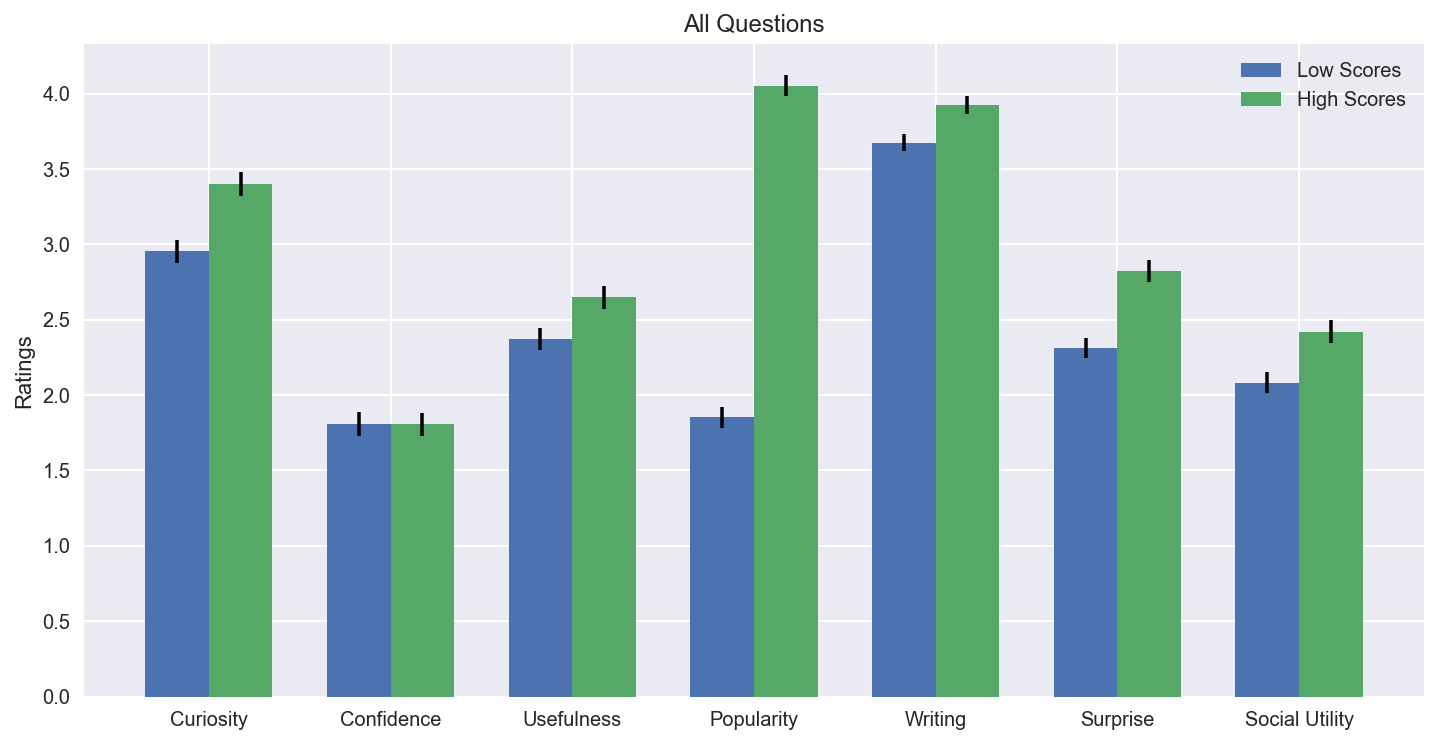

In [9]:
# Compute averages, run t-test and plot
PLOTTING_OPTIONS = {
    'y_label': 'Ratings',
    'ticks': ['Curiosity', 'Confidence', 'Usefulness',
              'Popularity', 'Writing', 'Surprise', 'Social Utility'],
    'legend': ['Low Scores', 'High Scores'],
    'title': 'All Questions',
    'size': (12, 6)
}

for index, j_label in enumerate(JUDGMENT_LABELS):
    low_data = data['{}_low'.format(j_label)]
    high_data = data['{}_high'.format(j_label)]
    print('{}: {}'.format(PLOTTING_OPTIONS['ticks'][index],
                          describe.paired_t_test(low_data, high_data)))

plotting.plot_double_bar(low_means, low_err, high_means,
                         high_err, **PLOTTING_OPTIONS)

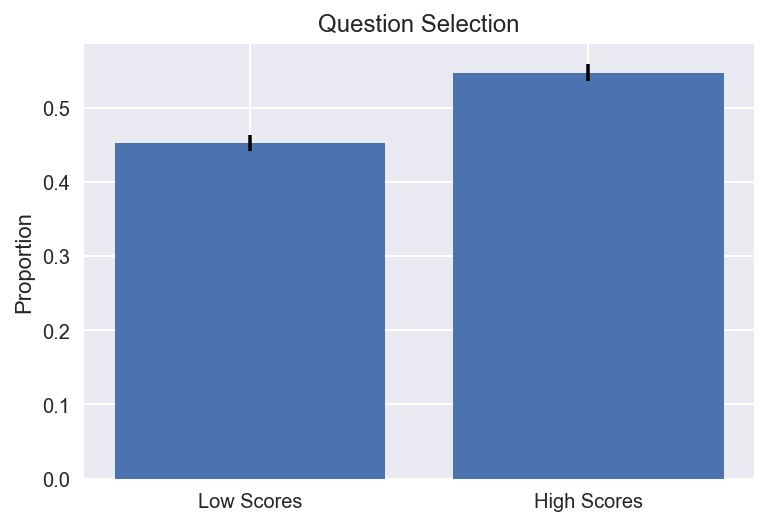

0.5475083056478407
t = 4.25, p = 2.87e-05 (greater)
Effect size: 0.09501661129568134


In [10]:
PLOTTING_OPTIONS = {
    'y_label': 'Proportion',
    'ticks': ['Low Scores', 'High Scores'],
    'title': 'Question Selection'
}

low_choice_labels = ['{}_choice'.format(q_label) for q_label in LOW_LABELS]
high_choice_labels = ['{}_choice'.format(q_label) for q_label in HIGH_LABELS]
low_choice_means = data[low_choice_labels].mean(axis=1)
high_choice_means = data[high_choice_labels].mean(axis=1)
low_mean = low_choice_means.mean()
high_mean = high_choice_means.mean()

plotting.plot_single_bar(
    [low_mean, high_mean],
    [low_choice_means.std() / math.sqrt(sample_size),
    high_choice_means.std() / math.sqrt(sample_size)],
    **PLOTTING_OPTIONS)

print(high_choice_means.mean())
print(describe.one_sample_t_test(high_choice_means, 0.5))
print('Effect size: {}'.format(high_mean - low_mean))

### Examining Participants Without Variance

New we consider elimating participants with little to no variance to determine if this had any noticable effect on our results. For example, particpant number two in our study had a variance of 0.2, meaning nearly ever response he or she gave was 3; we remove all such particpants and test for significance in the same way.

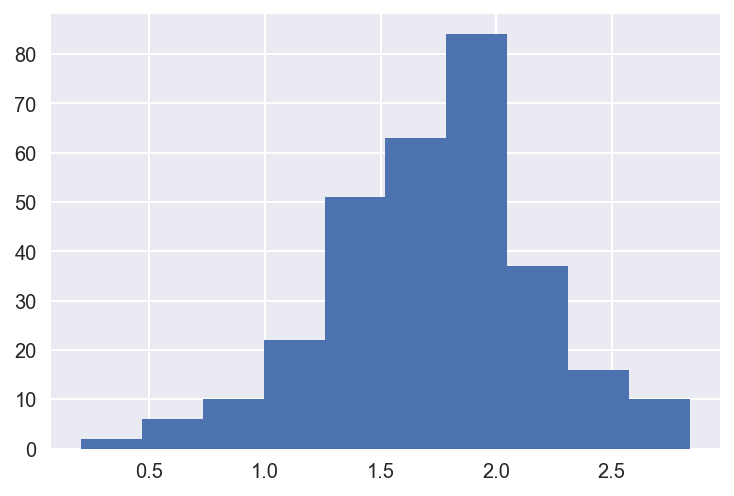

In [11]:
all_judgment_headers = ['{}_{}'.format(q_label, j_label) for 
                        q_label, j_label in itertools.product(
                            ALL_LABELS, JUDGMENT_LABELS)]
data['total_var'] = data[all_judgment_headers].std(axis=1)
plt.hist(data['total_var'])
plt.show()

In [12]:
data = data[data.total_var > 0.5]
print('{} eliminated'.format(sample_size - len(data)))

PLOTTING_OPTIONS = {
    'ticks': ['Curiosity', 'Confidence', 'Usefulness',
              'Popularity', 'Writing', 'Surprise', 'Social Utility']}

for index, j_label in enumerate(JUDGMENT_LABELS):
    low_data = data['{}_low'.format(j_label)]
    high_data = data['{}_high'.format(j_label)]
    print('{}: {}'.format(PLOTTING_OPTIONS['ticks'][index],
                          describe.paired_t_test(low_data, high_data)))
    
space()
high_choice_labels = ['{}_choice'.format(q_label) for q_label in HIGH_LABELS]
high_choice_means = data[high_choice_labels].mean(axis=1)
high_mean = high_choice_means.mean()
print(describe.one_sample_t_test(high_choice_means, 0.5))
print('Effect size: {}'.format(2 * high_mean - 1))

2 eliminated
Curiosity: t = -6.68, p = 1.16e-10 (1 greater)
Confidence: t = 0.099, p = 0.921 (0 greater)
Usefulness: t = -4.85, p = 1.95e-06 (1 greater)
Popularity: t = -22.4, p = 7.16e-66 (1 greater)
Writing: t = -5.56, p = 6.13e-08 (1 greater)
Surprise: t = -6.46, p = 4.32e-10 (1 greater)
Social Utility: t = -6.36, p = 7.73e-10 (1 greater)

t = 4.14, p = 4.49e-05 (greater)
Effect size: 0.09297658862876279


### Mediation Analysis

In [13]:
# Aggreate all questions and choice
columns = [
    'votes', 'curiosity', 'confidence', 'usefulness', 'popularity',
    'writing', 'surprise', 'social_utility', 'choice']
flattened_data = {col: [] for col in columns}

for index, row in data.iterrows():
    for q_label in ALL_LABELS:
        level = 1 if row['{}_score'.format(q_label)] > 240.9 else 0
        flattened_data[columns[0]].append(level)
        flattened_data[columns[1]].append(row['{}_j0'.format(q_label)])
        flattened_data[columns[2]].append(row['{}_j1'.format(q_label)])
        flattened_data[columns[3]].append(row['{}_j2'.format(q_label)])
        flattened_data[columns[4]].append(row['{}_j3'.format(q_label)])
        flattened_data[columns[5]].append(row['{}_j4'.format(q_label)])
        flattened_data[columns[6]].append(row['{}_j5'.format(q_label)])
        flattened_data[columns[7]].append(row['{}_j6'.format(q_label)])
        flattened_data[columns[8]].append(row['{}_choice'.format(q_label)])

In [14]:
new_data = pd.DataFrame(flattened_data)
new_data.head()

,choice,confidence,curiosity,popularity,social_utility,surprise,usefulness,votes,writing
0,1.0,4.0,4.0,5.0,2.0,2.0,3.0,0,2.0
1,1.0,2.0,4.0,2.0,1.0,5.0,4.0,0,4.0
2,0.0,2.0,4.0,5.0,1.0,4.0,2.0,0,2.0
3,0.0,2.0,4.0,5.0,4.0,3.0,4.0,0,2.0
4,0.0,3.0,4.0,2.0,1.0,3.0,4.0,0,3.0


In [15]:
input_columns = columns[1:8]
X = new_data[input_columns]
y = new_data['choice']
X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
results = logit_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.621223
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 choice   No. Observations:                 2990
Model:                          Logit   Df Residuals:                     2982
Method:                           MLE   Df Model:                            7
Date:                Fri, 26 Jan 2018   Pseudo R-squ.:                  0.1038
Time:                        16:43:47   Log-Likelihood:                -1857.5
converged:                       True   LL-Null:                       -2072.5
                                        LLR p-value:                 8.286e-89
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.2390      0.135     -9.160      0.000      -1.504      -0.974
curiosity          0.3329      0.027     12.193      0.000       0.279       0.386
confidence        -0.0987      0.023     -4.304      0.000      -0.144      -0.054
usefulness         0.0656      0.033      1.999      0.046       0.001       0.130
popularity         0.0275      0.022      1.229      0.219      -0.016       0.071
writing            0.0334      0.029      1.149      0.251      -0.024       0.090
surprise          -0.0428      0.022     -1.982      0.047      -0.085      -0.000
social_utility     0.0400      0.032      1.230      0.219      -0.024       0.104
==================================================================================
"""

In [16]:
# Popularity
X = new_data['popularity']
y = new_data['choice']
X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
results = logit_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.683819
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 choice   No. Observations:                 2990
Model:                          Logit   Df Residuals:                     2988
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jan 2018   Pseudo R-squ.:                 0.01346
Time:                        16:43:47   Log-Likelihood:                -2044.6
converged:                       True   LL-Null:                       -2072.5
                                        LLR p-value:                 8.090e-14
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4155      0.067     -6.187      0.000      -0.547      -0.284
popularity     0.1408      0.019      7.407      0.000       0.104       0.178
==============================================================================
"""

In [17]:
# Curiosity
X = new_data['curiosity']
y = new_data['choice']
X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
results = logit_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.626648
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 choice   No. Observations:                 2990
Model:                          Logit   Df Residuals:                     2988
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jan 2018   Pseudo R-squ.:                 0.09594
Time:                        16:43:47   Log-Likelihood:                -1873.7
converged:                       True   LL-Null:                       -2072.5
                                        LLR p-value:                 1.775e-88
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2763      0.079    -16.058      0.000      -1.432      -1.120
curiosity      0.3990      0.021     18.664      0.000       0.357       0.441
==============================================================================
"""

In [18]:
# Both
X = new_data[['popularity', 'curiosity']]
y = new_data['choice']
X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
results = logit_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.626329
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 choice   No. Observations:                 2990
Model:                          Logit   Df Residuals:                     2987
Method:                           MLE   Df Model:                            2
Date:                Fri, 26 Jan 2018   Pseudo R-squ.:                 0.09640
Time:                        16:43:47   Log-Likelihood:                -1872.7
converged:                       True   LL-Null:                       -2072.5
                                        LLR p-value:                 1.712e-87
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3337      0.090    -14.821      0.000      -1.510      -1.157
popularity     0.0294      0.021      1.383      0.167      -0.012       0.071
curiosity      0.3899      0.022     17.474      0.000       0.346       0.434
==============================================================================
"""